# Environments

In [36]:
import os
import optax
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

import lofi_tabular as experiment

In [38]:
import jax
import jax.numpy as jnp
from bandits.environments.tabular_env import TabularEnvironment
from bandits.environments.mnist_env import MnistEnvironment

In [39]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


```python
from bandits.environments import SomeEnv
from bandits.agents.bayes_agent import BayesAgent
from bandits import training as btrain

env_kwargs = {...}
bandit_kwargs = {...}

env = SomeEnv(*env_kwargs)
bandit = BayesAgent(**bandit_kwargs)

key = jax.random.PRNGkey(...)
key_warm, key_run = jax.random.split(key)
bel_warmup, output_warmup = btrain.warmup_bandit(key_warmup, bandit, env, npulls)
bel_bandit, output_train = btrain.run_bandit(key_run, bandit, bel_warmup, env, t_init=npulls)
```

In [40]:
key = jax.random.PRNGKey(314)
n_train = 5000
name = "statlog"
path = "../bandit-data/"

env = TabularEnvironment(key, name, n_train, path=path)
type(env)

bandits.environments.environment.BanditEnvironment

# Eval

In [41]:
"""
In this demo, we evaluate the performance of the
lofi bandit on a tabular dataset
"""
import jax
import pickle
import numpy as np
import flax.linen as nn
from datetime import datetime
from bayes_opt import BayesianOptimization
from bandits import training as btrain
from bandits.agents.linear_bandit import LinearBandit
from bandits.agents.low_rank_filter_bandit import LowRankFilterBandit
from bandits.agents.neural_linear import NeuralLinearBandit
from bandits.environments.tabular_env import TabularEnvironment

class MLP(nn.Module):
    num_arms: int

    @nn.compact
    def __call__(self, x):
        # x = nn.Dense(50)(x)
        # x = nn.relu(x)
        x = nn.Dense(50, name="last_layer")(x)
        x = nn.relu(x)
        x = nn.Dense(self.num_arms)(x)
        return x

In [42]:
ntrials = 1
npulls = 20
key = jax.random.PRNGKey(314)
key_env, key_train, key_eval = jax.random.split(key, 3)

ntrain = 500 # 5000
env = TabularEnvironment(key_env, ntrain=ntrain, name='statlog', intercept=False, path="../bandit-data")
env = MnistEnvironment(key, ntrain=ntrain)

num_arms = env.labels_onehot.shape[-1]
model = MLP(num_arms)

In [43]:
optimisers = {}
results = {}

## LoFi

In [57]:
name_agent = "lofi"
extra_params = {
    "memory_size": 10,
    "model": model,

}

def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_lofi,
        LowRankFilterBandit,
        env,
        key_train,
        npulls,
        **extra_params,
    )

    
    return res["hist_train"]["rewards"].sum()

In [58]:
%%time
pbounds = {
    "log_em_cov": [-10, -2.3],
    "log_init_cov": [-10, -7],
    "log_1m_dweights": [-18, -6],
    "log_dcov": [-18, -6],
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=10, n_iter=15)

|   iter    |  target   | log_1m... | log_dcov  | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | 52.0      | -12.89    | -9.565    | -3.466    | -9.987    |
| 2         | 176.0     | -16.99    | -17.91    | -6.12     | -8.557    |
| 3         | 63.0      | -7.491    | -7.542    | -2.571    | -7.201    |
| 4         | 162.0     | -17.55    | -16.42    | -5.171    | -8.178    |
| 5         | 156.0     | -7.93     | -9.276    | -5.691    | -9.101    |
| 6         | 179.0     | -13.32    | -11.52    | -9.64     | -8.417    |
| 7         | 38.0      | -14.33    | -17.42    | -2.665    | -9.732    |
| 8         | 75.0      | -13.91    | -13.47    | -2.623    | -8.02     |
| 9         | 185.0     | -17.77    | -11.91    | -6.876    | -9.934    |
| 10        | 178.0     | -6.507    | -13.88    | -7.729    | -8.387    |
| 11        | 164.0     | -17.78    | -15.15    | -9.965    | -8.456    |
| 12        | 178.0     | -7.857    | 

In [59]:
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_lofi,
    LowRankFilterBandit,
    env,
    key_eval,
    npulls,
    n_trials=10,
    **extra_params,
)

results[name_agent] = res
optimisers[name_agent] = optimiser

## Linear

In [47]:
name_agent = "linear"
extra_params = {
    "model": model,

}

def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_linear,
        LinearBandit,
        env,
        key_train,
        npulls,
    )

    
    return res["hist_train"]["rewards"].sum()

In [50]:
%%time
pbounds = {
    "eta": [0, 10],
    "log_lambda": [-8, 0],
}

optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=10, n_iter=15)

|   iter    |  target   |    eta    | log_la... |
-------------------------------------------------
| 1         | 60.0      | 4.262     | -2.377    |
| 2         | 43.0      | 8.486     | -7.964    |
| 3         | 43.0      | 0.8413    | -7.942    |
| 4         | 45.0      | 5.039     | -4.152    |
| 5         | 61.0      | 8.757     | -1.028    |
| 6         | 60.0      | 9.649     | -0.5349   |
| 7         | 43.0      | 0.375     | -6.947    |
| 8         | 51.0      | 6.271     | -3.141    |
| 9         | 61.0      | 8.392     | -2.184    |
| 10        | 43.0      | 5.597     | -5.603    |
| 11        | 77.0      | 3.208     | 0.0       |
| 12        | 124.0     | 0.347     | 0.0       |
| 13        | 220.0     | 0.0       | -1.201    |
| 14        | 148.0     | 0.0       | -2.354    |
| 15        | 77.0      | 0.7417    | -1.36     |
| 16        | 199.0     | 0.007891  | -1.257    |
| 17        | 127.0     | 0.1318    | -1.115    |
| 18        | 64.0      | 9.517     | -1.392    |


In [51]:
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_linear,
    LinearBandit,
    env,
    key_eval,
    npulls,
    n_trials=10,
)

results[name_agent] = res
optimisers[name_agent] = optimiser

## Neural linear

In [52]:
name_agent = "neural_linear"
extra_params = {
    "model": model,

}

def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_neural_linear,
        NeuralLinearBandit,
        env,
        key_train,
        npulls,
        **extra_params
    )
    
    return res["hist_train"]["rewards"].sum()

In [53]:
%%time
pbounds = {
    "eta": [0, 10],
    "log_lambda": [-8, 0],
    "log_lr": [-10, -2]
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=10, n_iter=15)

|   iter    |  target   |    eta    | log_la... |  log_lr   |
-------------------------------------------------------------
| 1         | 45.0      | 4.262     | -2.377    | -3.211    |
| 2         | 107.0     | 0.04448   | -7.327    | -9.942    |
| 3         | 43.0      | 5.039     | -4.152    | -2.994    |
| 4         | 51.0      | 8.715     | -0.2811   | -2.535    |
| 5         | 50.0      | 0.375     | -6.947    | -4.983    |
| 6         | 81.0      | 6.073     | -1.286    | -4.184    |
| 7         | 75.0      | 5.597     | -5.603    | -6.882    |
| 8         | 43.0      | 5.402     | -7.626    | -5.778    |
| 9         | 43.0      | 3.058     | -7.616    | -2.379    |
| 10        | 88.0      | 0.8946    | -5.275    | -6.983    |
| 11        | 100.0     | 0.1762    | -7.009    | -9.487    |
| 12        | 70.0      | 1.808     | -8.0      | -10.0     |
| 13        | 177.0     | 0.0       | -5.555    | -10.0     |
| 14        | 195.0     | 0.0       | -4.432    | -10.0     |
| 15    

In [54]:
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_neural_linear,
    NeuralLinearBandit,
    env,
    key_eval,
    npulls,
    n_trials=10,
    **extra_params
)

results[name_agent] = res
optimisers[name_agent] = optimiser

## Plot results

Text(0.5, 1.0, 'MNIST environment')

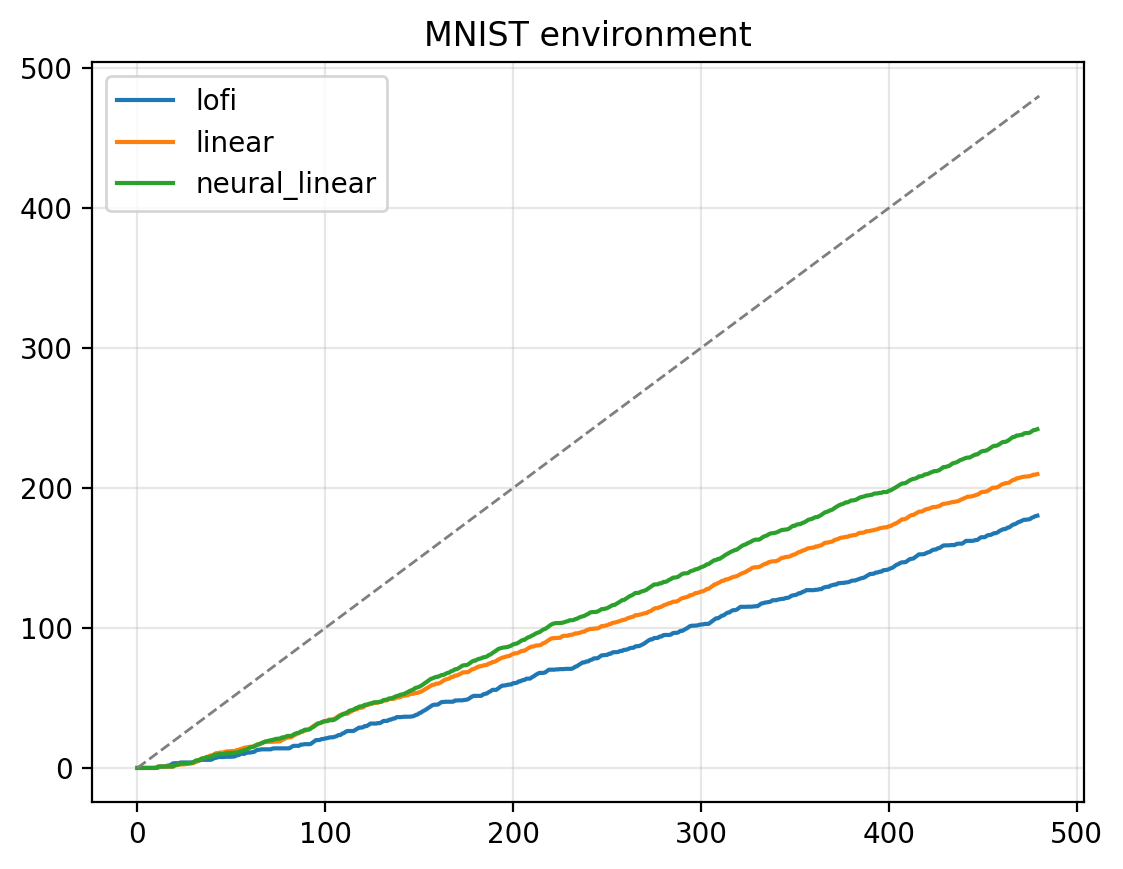

In [60]:
for name, res in results.items():
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()

    rewards = pd.DataFrame(rewards).T.cumsum(axis=0)

    nsteps = len(rewards)
    rewards.mean(axis=1).plot(label=name)
plt.plot([0, nsteps], [0, nsteps], c="tab:gray", linewidth=1, linestyle="--")
plt.legend()
plt.grid(alpha=0.3)
plt.title("MNIST environment")